In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import cv2
from pathlib import Path
import skimage.io as io
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import os
import pickle
import pydicom
from metrics import Pfbeta

In [3]:
DATA_DIR = Path('input/rsna-breast-cancer-detection/')

In [4]:
train = pd.read_csv(DATA_DIR/'train.csv')

# Load experiment

In [5]:
from datasets import *
from architectures import *
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torch
from transforms import *
from configs import *
from kuma_utils.utils import sigmoid
from sklearn.metrics import roc_auc_score

In [6]:
# def plot_color_gradients(cmap_name):
#     gradient = np.linspace(0, 1, 256)
#     gradient = np.vstack((gradient, gradient))
#     # Create figure and adjust figure height to number of colormaps
#     plt.figure(figsize=(10, 1))
#     plt.imshow(gradient, aspect='auto', cmap=plt.cm.get_cmap(cmap_name))
#     plt.axis('off')

# plot_color_gradients('jet')

In [7]:
# cfg = Dataset02v0()
# ds = PatientLevelDataset(
#     df=train, image_dir=Path('input/rsna-breast-cancer-detection/image_resized_1024W'),
#     flip_lr=False,
#     preprocess=A.Compose([AutoFlip(), CropROI(threshold=0.1, buffer=160), A.Resize(768, 384)]),
#     transforms=ToTensorV2(),
#     # preprocess=cfg.preprocess['train'],
#     # transforms=cfg.transforms['train']
# )

In [8]:
cfg = Model05v3aug0()
# model = cfg.model(**cfg.model_params)

In [9]:
with open(f'results/{cfg.name}/predictions.pickle', 'rb') as f:
    predictions = pickle.load(f)

In [10]:
SAMPLE_ID = {
    42624, 48001, 48514, 2179, 31107, 23554, 13185, 53255, 
    29192, 59530, 64908, 32527, 13845, 59552, 54816, 49954, 
    55330, 59307, 21934, 63536, 23729, 61490, 61874, 16955, 
    46014, 38727, 64456, 50375, 9162, 55755, 25550, 15696, 
    50002, 58195, 10198, 13016, 25050, 31581, 26333, 29664, 
    8289, 3305, 6637, 48493, 58610, 42231, 12282, 9083, 32252, 39677}

In [11]:
metric = Pfbeta(binarize=True)

In [12]:
# for fold_i, (folds, pred_fold) in enumerate(zip(predictions['folds'], predictions['outoffolds'])):
#     ds = cfg.dataset(
#         df=train.iloc[folds[1]], 
#         image_dir=Path('input/rsna-breast-cancer-detection/image_resized_1024W'),
#         is_test=True,
#         preprocess=cfg.preprocess['test'],
#         transforms=ToTensorV2())
#     labels = ds.get_labels().reshape(-1)
#     pred = sigmoid(pred_fold).reshape(-1)
#     hard_samples = np.argsort(np.abs(labels - pred))[::-1][:20]
#     for idx in hard_samples:
#         img, label = ds[idx]
#         plt.figure(figsize=(12, 4))
#         plt.suptitle(f'{ds.pids[idx]}/ {label[0].item()}/ {pred[idx]:5f}')
#         for i in range(img.shape[0]):
#             plt.subplot(1, img.shape[0], i+1)
#             plt.imshow(img[i, 0], cmap='gray')
#         # plt.show()
#         plt.savefig(f'input/plot2/fold{fold_i}_{idx}.png', facecolor='white')
#         plt.close()
#     # scores, thres = metric.optimal_f1_all(labels, pred)
#     # plt.plot(scores)
#     # plt.title(f'fold{fold_i} MAX: {max(scores):.5f} AUC: {sum(scores):.5f}')
#     # plt.show()

In [9]:
def aggregate_results(cfg):
    with open(f'results/{cfg.name}/predictions.pickle', 'rb') as f:
        predictions = pickle.load(f)
    metric = Pfbeta(binarize=True)
    res_df = []
    for fold_i, (folds, pred_fold) in enumerate(zip(predictions['folds'], predictions['outoffolds'])):
        ds = cfg.dataset(
            df=train.iloc[folds[1]], image_dir=None)
        for i in range(len(ds)):
            record = ds.df_dict[ds.pids[i]]
            res_df.append({
                'pred': sigmoid(pred_fold[i][0]), 
                'label': record['cancer'].values[0],
                'site': record['site_id'].values[0],
                'machine_id': record['machine_id'].values[0]})
    res_df = pd.DataFrame(res_df)
    return res_df


def subgroup_analysis(df, col='site'):
    res = [{
        'value': f'{col}_overall', 
        'PF1': metric.optimal_f1(df['label'].values, df['pred'].values) if df['label'].sum() > 0 else 'NaN',
        'AUC': roc_auc_score(df['label'].values, df['pred'].values) if df['label'].sum() > 0 else 'NaN'
    }]
    for gid, gdf in df.groupby(col):
        res.append({
            'value': f'{col}_{gid}', 
            'PF1': metric.optimal_f1(gdf['label'].values, gdf['pred'].values) if gdf['label'].sum() > 0 else 'NaN',
            'AUC': roc_auc_score(gdf['label'].values, gdf['pred'].values) if gdf['label'].sum() > 0 else 'NaN'
        })
    res = pd.DataFrame(res)
    return res


In [27]:
agg_df = aggregate_results(Model05v3aug0)
display(subgroup_analysis(agg_df, 'site'))
display(subgroup_analysis(agg_df, 'machine_id'))


,value,PF1,AUC
0,site_overall,"(0.44369369369369366, 0.21)",0.884367
1,site_1,"(0.3644251626898048, 0.22)",0.857709
2,site_2,"(0.5355450236966826, 0.21)",0.908317


,value,PF1,AUC
0,machine_id_overall,"(0.44369369369369366, 0.21)",0.884367
1,machine_id_21,"(0.5223880597014926, 0.19)",0.900304
2,machine_id_29,"(0.5481481481481483, 0.2)",0.909318
3,machine_id_48,"(0.5555555555555556, 0.61)",0.92069
4,machine_id_49,"(0.37735849056603765, 0.22)",0.848337
5,machine_id_93,"(0.33333333333333337, 0.44)",0.829313
6,machine_id_170,"(0.4615384615384615, 0.06)",0.887366
7,machine_id_190,"(0.03773584905660378, 0.0)",0.882353
8,machine_id_197,NaN,NaN
9,machine_id_210,NaN,NaN


In [26]:
agg_df = aggregate_results(Baseline4)
display(subgroup_analysis(agg_df, 'site'))
display(subgroup_analysis(agg_df, 'machine_id'))


,value,PF1,AUC
0,site_overall,"(0.43966547192353644, 0.34)",0.875412
1,site_1,"(0.35294117647058826, 0.26)",0.840524
2,site_2,"(0.5336538461538461, 0.32)",0.908185


,value,PF1,AUC
0,machine_id_overall,"(0.43966547192353644, 0.34)",0.875412
1,machine_id_21,"(0.5255474452554746, 0.24)",0.903375
2,machine_id_29,"(0.5174825174825175, 0.31)",0.913015
3,machine_id_48,"(0.5833333333333334, 0.33)",0.909997
4,machine_id_49,"(0.3627684964200477, 0.26)",0.836223
5,machine_id_93,"(0.33333333333333337, 0.8200000000000001)",0.920882
6,machine_id_170,"(0.5263157894736842, 0.19)",0.803495
7,machine_id_190,"(0.2222222222222222, 0.01)",0.882353
8,machine_id_197,NaN,NaN
9,machine_id_210,NaN,NaN


In [28]:
agg_df = aggregate_results(AuxLoss00)
display(subgroup_analysis(agg_df, 'site'))
display(subgroup_analysis(agg_df, 'machine_id'))


,value,PF1,AUC
0,site_overall,"(0.43645083932853723, 0.3)",0.881930
1,site_1,"(0.36448598130841126, 0.3)",0.844627
2,site_2,"(0.5225653206650832, 0.25)",0.916229


,value,PF1,AUC
0,machine_id_overall,"(0.43645083932853723, 0.3)",0.88193
1,machine_id_21,"(0.5027932960893856, 0.06)",0.923085
2,machine_id_29,"(0.5323741007194244, 0.25)",0.910674
3,machine_id_48,"(0.5655172413793104, 0.35000000000000003)",0.916046
4,machine_id_49,"(0.3869346733668341, 0.3)",0.837247
5,machine_id_93,"(0.33333333333333337, 0.65)",0.833982
6,machine_id_170,"(0.3636363636363636, 0.08)",0.853763
7,machine_id_190,"(0.03773584905660378, 0.0)",0.941176
8,machine_id_197,NaN,NaN
9,machine_id_210,NaN,NaN


In [29]:
agg_df = aggregate_results(Res00aug0)
display(subgroup_analysis(agg_df, 'site'))
display(subgroup_analysis(agg_df, 'machine_id'))


,value,PF1,AUC
0,site_overall,"(0.4675324675324676, 0.42)",0.903614
1,site_1,"(0.375, 0.39)",0.870219
2,site_2,"(0.57002457002457, 0.29)",0.930831


,value,PF1,AUC
0,machine_id_overall,"(0.4675324675324676, 0.42)",0.903614
1,machine_id_21,"(0.6016260162601627, 0.4)",0.936075
2,machine_id_29,"(0.523489932885906, 0.18)",0.905955
3,machine_id_48,"(0.611764705882353, 0.16)",0.950141
4,machine_id_49,"(0.38482384823848237, 0.37)",0.85749
5,machine_id_93,"(0.28571428571428575, 0.77)",0.894942
6,machine_id_170,"(0.5333333333333333, 0.42)",0.945968
7,machine_id_190,"(0.6666666666666666, 0.03)",0.980392
8,machine_id_197,NaN,NaN
9,machine_id_210,NaN,NaN


# Stability analysis

In [13]:
res = aggregate_results(Baseline4)
res.head()

,pred,label,site,machine_id
0,0.000147,0,1,49
1,0.000158,0,1,49
2,0.000307,0,1,49
3,0.000457,0,1,49
4,0.000178,0,2,29


In [12]:
metric = Pfbeta(binarize=True)

In [14]:
metric.optimal_f1(res['label'], res['pred'])

(0.43966547192353644, 0.34)

In [15]:
res['pred_bin'] = (res['pred'] > 0.34).astype(int)

In [24]:
scores = []
for i in tqdm(range(1000)):
    res_sample = res.sample(2200*2) # per breast
    scores.append(metric.pfbeta(res_sample['label'].values, res_sample['pred_bin'].values))

  0%|          | 0/1000 [00:00<?, ?it/s]

<AxesSubplot:ylabel='Count'>

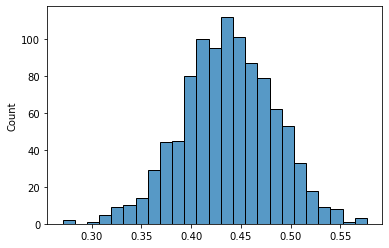

In [25]:
sns.histplot(scores)

# Use metadata ? 

In [17]:
from sklearn.linear_model import LogisticRegression

In [30]:
for fold_i, (folds, pred_fold) in enumerate(zip(predictions['folds'], predictions['outoffolds'])):
    ds = cfg.dataset(df=train.iloc[folds[1]], image_dir=None)
    labels = ds.get_labels()
    pred = sigmoid(pred_fold).reshape(-1)
    print(metric.optimal_f1(labels, pred))
    stack_x = pd.DataFrame({
        'pred': pred,
        'age': [ds.df_dict[ds.pids[i]]['age'].values[0] / 100 for i in range(len(ds))]
    })
    stack_x['age'] = stack_x['age'].fillna(stack_x['age'].mean())
    model = LogisticRegression()
    model.fit(stack_x, labels.reshape(-1))
    pred2 = model.predict_proba(stack_x)[:, 1]
    print(metric.optimal_f1(labels, pred2))
    

(0.425, 0.64)
(0.42236024844720493, 0.22)
(0.4174757281553398, 0.13)
(0.4161849710982659, 0.05)
(0.5681818181818182, 0.31)
(0.5654450261780104, 0.05)
(0.5, 0.28)
(0.48837209302325585, 0.09)
(0.42276422764227634, 0.65)
(0.42975206611570244, 0.39)
